In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole

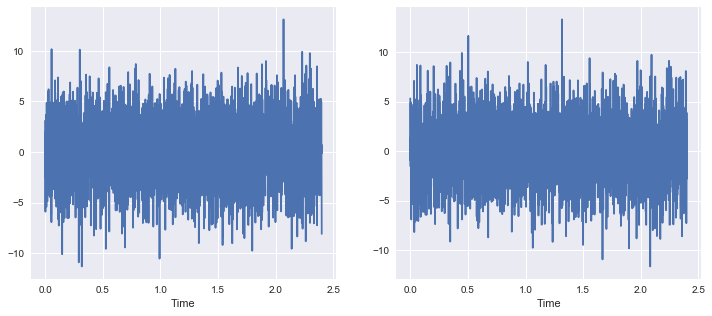

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

frequency_of_interest = 200
sampling_frequency = 1500
time_extent = (0, 2.400)
n_trials = 100
n_time_samples = int((time_extent[1] - time_extent[0]) * sampling_frequency) + 1
time = np.linspace(time_extent[0], time_extent[1], num=n_time_samples, endpoint=True)
signal1 = np.sin(2 * np.pi * time * frequency_of_interest)
signal1 = signal1[:, np.newaxis] * np.ones((n_time_samples, n_trials))
# Randomized phase until time > 1.5
phase_offset = np.random.uniform(-np.pi, np.pi, size=time.shape)
phase_offset[np.where(time > 1.5)] = np.pi / 2
signal2 = np.sin((2 * np.pi * time * frequency_of_interest) + phase_offset)
signal2 = signal2[:, np.newaxis] * np.ones((n_time_samples, n_trials))
noise1 = np.random.normal(0, 3, size=(n_time_samples, n_trials))
noise2 = np.random.normal(0, 3, size=(n_time_samples, n_trials))

data = [signal1 + noise1, signal2 + noise2]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for datum, ax in zip(data, axes):
    ax.plot(time, datum[:, 0])
    ax.set_xlabel('Time')

In [3]:
from itertools import combinations
from src.spectral import _cross_spectrum

def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.

    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.

    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.

    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
           
    References
    ----------
    .. [1] https://gist.github.com/nils-werner/9d321441006b112a4b116a8387c2280c

    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided

    
def _reshape(fourier_coefficients):
    n_signals = len(fourier_coefficients)
    n_time_samples, _, n_fft_samples, _ = fourier_coefficients[0].shape
    return np.stack(fourier_coefficients, axis=2).swapaxes(1, 3).reshape(
        (n_time_samples, n_fft_samples, n_signals, -1))

def _complex_inner_product(a, b):
    return np.matmul(a, b.conj().swapaxes(-1, -2))

def compute_cross_spectra(fourier_coefficients):
    auto_spectra = [_cross_spectrum(coefficients, coefficients)
                    for coefficients in fourier_coefficients]
    cross_spectra = [_cross_spectrum(coefficients1, coefficients2)
                     for coefficients1, coefficients2
                     in combinations(fourier_coefficients, 2)]
    return auto_spectra, cross_spectra


from scipy.fftpack import fft

def _multitaper_fft(tapers, time_series, n_fft_samples,
                    sampling_frequency, axis=0):
    '''Projects the data on the tapers and returns the discrete Fourier
    transform

    Parameters
    ----------
    tapers : array_like, shape (n_time_samples, n_tapers)
    time_series : array_like, shape (n_windows, n_trials, n_time_samples)
    n_fft_samples : int
    sampling_frequency : int

    Returns
    -------
    fourier_coefficients : array_like, shape (n_windows, n_trials,
                                              n_fft_samples, n_tapers)

    '''
    n_dims = len(time_series.shape[:-1])
    projected_time_series = (np.reshape(time_series, (*time_series.shape, 1)) *
                             np.reshape(tapers, (1, 1, *tapers.shape)))
    return (fft(projected_time_series, n=n_fft_samples, axis=axis) /
            sampling_frequency)

In [5]:
from src.spectral import (_get_window_lengths, _set_default_multitaper_parameters, _get_tapers)
from scipy.signal import detrend

time_window_duration=0.080
time_window_step=0.080
sampling_frequency = 1500
time_halfbandwidth_product = 2
desired_frequencies=[0, 300]
pad = 0
tapers = None
n_tapers = None

n_samples_per_time_step, n_time_samples = _get_window_lengths(
    time_window_duration,
    sampling_frequency,
    time_window_step)
tapers, n_fft_samples, frequencies, frequency_index = (
    _set_default_multitaper_parameters(
        n_time_samples=n_time_samples,
        sampling_frequency=sampling_frequency, tapers=tapers,
        n_tapers=n_tapers,
        time_halfbandwidth_product=time_halfbandwidth_product,
        desired_frequencies=desired_frequencies, pad=pad))

time_series = data.copy()
time_series = [sliding_window(series, size=n_time_samples,
                              stepsize=n_samples_per_time_step, axis=0)
               for series in time_series]
time_series = [detrend(series) for series in time_series]
fourier_coefficients = [_multitaper_fft(tapers, series, n_fft_samples,
                                        sampling_frequency, axis=2)
                        for series in time_series]

auto_spectra, cross_spectra = compute_cross_spectra(fourier_coefficients)


In [4]:
def expectation(x): return np.nanmean(x, axis=(1, 3))

def power(auto_spectra):
    return [np.abs(spectrum) ** 2 for spectrum in auto_spectra]


def coherency(auto_spectra, cross_spectra):
    spectra_index = combinations(range(len(auto_spectra)), 2)
    return [
        expectation(cross_spectrum) /
        np.sqrt(expectation(auto_spectra[series_ind1]) *
                expectation(auto_spectra[series_ind2]))
        for cross_spectrum, (series_ind1, series_ind2)
        in zip(cross_spectra, spectra_index)]


def imaginary_coherence(auto_spectra, cross_spectra):
    spectra_index = combinations(range(len(auto_spectra)), 2)
    return [
        np.abs(
            np.imag(expectation(cross_spectrum)) /
            np.sqrt(expectation(auto_spectra[series_ind1]) *
                    expectation(auto_spectra[series_ind2])))
        for cross_spectrum, (series_ind1, series_ind2)
        in zip(cross_spectra, spectra_index)]


def phase_locking_value(cross_spectra):
    return [expectation(spectrum / np.abs(spectrum))
            for spectrum in cross_spectra]


def phase_lag_index(cross_spectra):
    return [expectation(np.sign(np.imag(spectrum)))
            for spectrum in cross_spectra]


def weighted_phase_lag_index(cross_spectra):
    return [expectation(np.sign(np.imag(spectrum))) /
            expectation(np.abs(np.imag(spectrum)))
            for spectrum in cross_spectra]


def _normalize_fourier_coefficients(fourier_coefficients):
    U, _, V = np.linalg.svd(_reshape(fourier_coefficients), full_matrices=False)
    return np.matmul(U, V)


def _estimate_canonical_coherency(fourier_coefficients1, fourier_coefficients2):
    group_cross_spectrum = _complex_inner_product(fourier_coefficients1, fourier_coefficients2)
    return np.linalg.svd(group_cross_spectrum, full_matrices=False, compute_uv=False)[:, :, 0]


def canonical_coherence(fourier_coefficients, group_labels):
    normalized_fourier_coefficients = [
        _normalize_fourier_coefficients(fourier_coefficients[:, :, label == group_labels, ...])
        for label in np.unique(group_labels)]
    return [_estimate_canonical_coherency(fourier_coefficients1, fourier_coefficients2)
            for fourier_coefficients1, fourier_coefficients2
            in combinations(normalized_fourier_coefficients, 2)]

plt.pcolormesh(np.abs(coherency(auto_spectra, cross_spectra)[0]).T, cmap='viridis');

NameError: name 'auto_spectra' is not defined

## Alternate implementation involving matrix multiplications

In [7]:
time_series = np.stack(data.copy(), axis=-1)
time_series = sliding_window(time_series, size=n_time_samples,
                             stepsize=n_samples_per_time_step, axis=0)
detrend_type = 'linear'
time_series = detrend(time_series, type=detrend_type)
fourier_coefficients = _multitaper_fft(tapers, time_series, n_fft_samples,
                                       sampling_frequency, axis=3)


def compute_cross_spectral_matrix(fourier_coefficients):
    '''
    Parameters
    ----------
    fourier_coefficients : array-like, shape (n_time_samples, n_trials,
                                              n_signals, n_fft_samples,
                                              n_tapers)
                                              
    Returns
    -------
    cross_spectral_matrix : array-like, shape (n_time_samples, n_trials,
                                               n_tapers, n_fft_samples,
                                               n_signals, n_signals)
    '''
    fourier_coefficients = np.expand_dims(fourier_coefficients.swapaxes(2, -1), -1)
    return _complex_inner_product(fourier_coefficients, fourier_coefficients)
                                   
cross_spectral_matrix = compute_cross_spectral_matrix(fourier_coefficients)

In [8]:
from functools import partial
from inspect import signature
from scipy.fftpack import ifft

EXPECTATION = {
    'trials': partial(np.mean, axis=1),
    'tapers': partial(np.mean, axis=2),
    'trials_tapers': partial(np.mean, axis=(1, 2))
}


def power(cross_spectral_matrix=None, fourier_coefficients=None,
          expectation=EXPECTATION['trials_tapers']):
    if cross_spectral_matrix is None:
        fourier_coefficients = fourier_coefficients.swapaxes(2, -1)
        auto_spectra = expectation(fourier_coefficients *
                                   fourier_coefficients.conjugate())
    else:
        auto_spectra = expectation(np.diagonal(cross_spectral_matrix, 0, -2, -1))
    return auto_spectra.real


def coherency(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    power_spectra = power(cross_spectral_matrix=cross_spectral_matrix, expectation=expectation)
    return expectation(cross_spectral_matrix) / np.sqrt(
        power_spectra[..., :, np.newaxis] * power_spectra[..., np.newaxis, :])
                                   

def imaginary_coherence(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    auto_spectra = power(cross_spectral_matrix=cross_spectral_matrix, expectation=expectation)
    return np.abs(
        expectation(cross_spectral_matrix).imag /
        np.sqrt(auto_spectra[:, :, :, np.newaxis] * auto_spectra[:, :, np.newaxis, :]))


def phase_locking_value(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    return expectation(cross_spectral_matrix / np.abs(cross_spectral_matrix))
                                   
                                   
def phase_lag_index(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    return expectation(np.sign(cross_spectral_matrix.imag))


def weighted_phase_lag_index(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    pli = phase_lag_index(cross_spectral_matrix, expectation=expectation)
    weights = expectation(np.abs(cross_spectral_matrix.imag))
    with np.errstate(divide='ignore', invalid='ignore'):
        return pli / weights

def _get_number_observations(cross_spectral_matrix, expectation_function):
    return np.prod(
        [cross_spectral_matrix.shape[axis]
         for axis in signature(expectation_function).parameters['axis'].default])
    
def debiased_squared_phase_lag_index(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    n_observations = _get_number_observations(cross_spectral_matrix, expectation)
    pli = phase_lag_index(cross_spectral_matrix, expectation=expectation)
    return (n_observations * pli ** 2 - 1.0) / (n_observations - 1.0)


def debiased_squared_weighted_phase_lag_index(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    n_observations = _get_number_observations(cross_spectral_matrix, expectation)
    imaginary_cross_spectral_matrix_sum = expectation(cross_spectral_matrix.imag) * n_observations
    squared_imaginary_cross_spectral_matrix_sum = expectation(cross_spectral_matrix.imag ** 2) * n_observations
    imaginary_cross_spectral_matrix_magnitude_sum = expectation(np.abs(cross_spectral_matrix.imag)) * n_observations
    weights = imaginary_cross_spectral_matrix_magnitude_sum ** 2 - squared_imaginary_cross_spectral_matrix_sum
    return (imaginary_cross_spectral_matrix_sum ** 2 - squared_imaginary_cross_spectral_matrix_sum) / weights


def pairwise_phase_consistency(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    n_observations = _get_number_observations(cross_spectral_matrix, expectation)
    plv_sum = phase_locking_value(cross_spectral_matrix, expectation=expectation) * n_observations
    ppc = (plv_sum * plv_sum.conjugate() - n_observations) / (n_observations * (n_observations - 1.0))
    return ppc.real


def weighted_pairwise_phase_consistency(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    pass


def _conjugate_transpose(x):
    '''Conjugate transpose of the last two dimensions of array x'''
    return x.swapaxes(-1, -2).conjugate()


def _get_intial_conditions(cross_spectral_matrix):
    '''Returns a guess for the minimum phase factor'''
    return np.linalg.cholesky(
        ifft(cross_spectral_matrix, axis=-3)[..., 0:1, :, :].real
    ).swapaxes(-1, -2)


def _get_causal_signal(linear_predictor):
    '''Remove negative lags (the anti-casual part of the signal) and half of the zero lag
    to obtain the causal signal.
    Gives you A_(t+1)(Z) / A_(t)(Z)
    
    Takes half the roots on the unit circle (zero lag) and all the roots
    inside the unit circle (positive lags)
    
    This is the plus operator in Wilson
    '''
    n_signals, n_fft_samples = linear_predictor.shape[-1], linear_predictor.shape[-3]
    linear_predictor_coefficients = ifft(linear_predictor, axis=-3)
    linear_predictor_coefficients[..., 0, :, :] *= 0.5
    # Form S_tau
    lower_triangular_ind = np.tril_indices(n_signals, k=-1)
    linear_predictor_coefficients[..., 0, lower_triangular_ind[0], lower_triangular_ind[1]] = 0
    linear_predictor_coefficients[..., (n_fft_samples // 2) + 1:, :, :] = 0
    return fft(linear_predictor_coefficients, axis=-3)


def check_convergence(minimum_phase_factor, old_minimum_phase_factor, tolerance):
    '''Check convergence of Wilson algorithm at each time point'''
    n_time_points = minimum_phase_factor.shape[0]
    psi_error = np.linalg.norm(
        np.reshape(minimum_phase_factor - old_minimum_phase_factor, (n_time_points, -1)),
        ord=np.inf, axis=1)
    return psi_error < tolerance
    

def _minimum_phase_decomposition(cross_spectral_matrix, tolerance=1E-8, max_iterations=30):
    '''Using the Wilson algorithm to find a minimum phase matrix square root of the
    cross spectral density'''
    n_time_points, n_signals = cross_spectral_matrix.shape[0], cross_spectral_matrix.shape[-1]
    I = np.eye(n_signals)
    is_converged = np.zeros(n_time_points, dtype=bool)
    minimum_phase_factor = np.zeros(cross_spectral_matrix.shape)
    minimum_phase_factor[..., :, :, :] = _get_intial_conditions(cross_spectral_matrix)

    for iteration in range(max_iterations):
        old_minimum_phase_factor = minimum_phase_factor.copy()
        linear_predictor = (np.linalg.solve(
            minimum_phase_factor,
            _conjugate_transpose(np.linalg.solve(minimum_phase_factor, cross_spectral_matrix))) + I)
        minimum_phase_factor = np.matmul(minimum_phase_factor, _get_causal_signal(linear_predictor))
        
        minimum_phase_factor[is_converged, ...] = old_minimum_phase_factor[is_converged, ...]
        is_converged = check_convergence(minimum_phase_factor, old_minimum_phase_factor, tolerance)
        if np.all(is_converged):
            return minimum_phase_factor
    else:
        print('Maximum iterations reached. {} of {} converged'.format(
            is_converged.sum(), len(is_converged)))
        return minimum_phase_factor


def _estimate_noise_covariance(minimum_phase):
    A_0 = minimum_phase[..., 0, :, :]
    return np.matmul(A_0, A_0.swapaxes(-1, -2)).real


def _estimate_transfer_function(minimum_phase):
    return np.matmul(minimum_phase,
                     np.linalg.inv(minimum_phase[..., 0:1, :, :]))


def _transfer_magnitude(transfer_function):
    return np.abs(transfer_function) ** 2


def _remove_instantaneous_causality(noise_covariance):
    noise_covariance = noise_covariance[..., np.newaxis, :, :]
    variance = np.diagonal(noise_covariance, axis1=-1, axis2=-2)[..., np.newaxis] 
    return (_conjugate_transpose(variance) -
            noise_covariance * _conjugate_transpose(noise_covariance) / variance)


def _set_diagonal_to_zero(x):
    n_signals = x.shape[-1]
    diagonal_index = np.diag_indices(n_signals)
    x[..., diagonal_index[0], diagonal_index[1]] = 0
    return x


def spectral_granger_prediction(power_spectra, transfer_function, noise_covariance):
    transfer_magnitude = _transfer_magnitude(transfer_function)
    partial_covariance = _remove_instantaneous_causality(noise_covariance)
    power_spectra = power_spectra[..., np.newaxis]
    intrinsic_power = power_spectra - partial_covariance * transfer_magnitude
    return _set_diagonal_to_zero(np.log(power_spectra / intrinsic_power))


def nonparametric_spectral_granger(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    minimum_phase = _minimum_phase_decomposition(expectation(cross_spectral_matrix))
    noise_covariance = _estimate_noise_covariance(minimum_phase)
    transfer_function = _estimate_transfer_function(minimum_phase)
    power_spectra = power(cross_spectral_matrix=cross_spectral_matrix, expectation=expectation)
    return spectral_granger_prediction(power_spectra, transfer_function, noise_covariance)

def _total_inflow(transfer_magnitude, noise_variance):
    return np.sum(noise_variance * transfer_magnitude, keepdims=True, axis=-1)

def _get_noise_variance(noise_covariance):
    if noise_covariance is None:
        return 1.0
    else:
        return np.diagonal(noise_covariance, axis1=-1, axis2=-2)[..., np.newaxis]


def directed_transfer_function(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers'],
                               noise_covariance=None):
    minimum_phase = _minimum_phase_decomposition(expectation(cross_spectral_matrix))
    transfer_magnitude = _transfer_magnitude(_estimate_transfer_function(minimum_phase))
    noise_variance = _get_noise_variance(noise_covariance)
    return np.sqrt(noise_variance) * transfer_magnitude / _total_inflow(transfer_magnitude, noise_variance)


def _total_outflow(MVAR_Fourier_coefficients, noise_variance):
    return np.sum(
        (1.0 / noise_variance) * transfer_magnitude, keepdims=True, axis=-2)


def partial_directed_coherence(cross_spectral_matrix=None, MVAR_coefficients=None, transfer_function=None,
                               noise_covariance=None, expectation=EXPECTATION['trials_tapers']):
    if MVAR_coefficients is not None:
        pass
    elif transfer_function is not None:
        MVAR_Fourier_coefficients = np.linalg.inv(transfer_function)
    else:
        minimum_phase = _minimum_phase_decomposition(expectation(cross_spectral_matrix))
        transfer_function = _estimate_transfer_function(minimum_phase)
        MVAR_Fourier_coefficients = np.linalg.inv(transfer_function)
        
    noise_variance = _get_noise_variance(noise_covariance)

    return (MVAR_Fourier_coefficients * (1.0 / np.sqrt(noise_variance)) /
            _total_outflow(MVAR_Fourier_coefficients, noise_variance))


def direct_directed_transfer_function(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    minimum_phase = _minimum_phase_decomposition(expectation(cross_spectral_matrix))
    transfer_function = _estimate_transfer_function(minimum_phase)
    transfer_magnitude = _transfer_magnitude(transfer_function)
    full_frequency_DTF = transfer_magnitude / np.sum(_total_inflow(transfer_magnitude, 1.0), axis=-3, keepdims=True)
    partial_coherence = partial_directed_coherence(transfer_function=transfer_function)
    return full_frequency_DTF * partial_coherence


_CONNECTIVITY_MEASURES = {
    'power': power,
    'coherency': coherency,
    'imaginary_coherence': imaginary_coherence,
    'phase_locking_value': phase_locking_value, 
    'phase_lag_index': phase_lag_index,
    'weighted_phase_lag_index': weighted_phase_lag_index,
    'debiased_squared_phase_lag_index': debiased_squared_phase_lag_index,
    'debiased_squared_weighted_phase_lag_index': debiased_squared_weighted_phase_lag_index,
    'pairwise_phase_consistency': pairwise_phase_consistency,
    'weighted_pairwise_phase_consistency': weighted_pairwise_phase_consistency,
    'nonparametric_spectral_granger': nonparametric_spectral_granger,
    'directed_transfer_function': directed_transfer_function,
    'partial_directed_coherence': partial_directed_coherence,
    'direct_directed_transfer_function': direct_directed_transfer_function,
}


expectation_type = 'trials_tapers'
connectivity = {name: measure(cross_spectral_matrix, expectation=EXPECTATION[expectation_type])
                for name, measure in _CONNECTIVITY_MEASURES.items()}

Maximum iterations reached. 0 of 30 converged
Maximum iterations reached. 0 of 30 converged
Maximum iterations reached. 0 of 30 converged


NameError: name 'transfer_magnitude' is not defined

In [6]:
def directed_transfer_function(transfer_function, noise_covariance=None):
    transfer_magnitude = _transfer_magnitude(transfer_function)
    noise_variance = _get_noise_variance(noise_covariance)
    return np.sqrt(noise_variance) * transfer_magnitude / _total_inflow(transfer_magnitude, noise_variance)


def partial_directed_coherence(MVAR_coefficients=None, noise_covariance=None):
    noise_variance = _get_noise_variance(noise_covariance)
    return (MVAR_Fourier_coefficients * (1.0 / np.sqrt(noise_variance)) /
            _total_outflow(MVAR_Fourier_coefficients, noise_variance))


def direct_directed_transfer_function(transfer_function):
    transfer_magnitude = _transfer_magnitude(transfer_function)
    full_frequency_DTF = transfer_magnitude / np.sum(_total_inflow(transfer_magnitude, 1.0), axis=-3, keepdims=True)
    partial_coherence = partial_directed_coherence(transfer_function=transfer_function)
    return full_frequency_DTF * partial_coherence

## Playing with Dask

In [35]:
from dask import delayed, compute, visualize
from functools import partial
from inspect import signature
from scipy.fftpack import fft
from scipy.fftpack import ifft

EXPECTATION = {
    'trials': partial(np.mean, axis=1),
    'tapers': partial(np.mean, axis=2),
    'trials_tapers': partial(np.mean, axis=(1, 2))
}


def _conjugate_transpose(x):
    '''Conjugate transpose of the last two dimensions of array x'''
    return x.swapaxes(-1, -2).conjugate()


def _complex_inner_product(a, b):
    return np.matmul(a, _conjugate_transpose(b))


@delayed
def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.

    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.

    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.

    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
           
    References
    ----------
    .. [1] https://gist.github.com/nils-werner/9d321441006b112a4b116a8387c2280c

    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided

@delayed
def _multitaper_fft(tapers, time_series, n_fft_samples,
                    sampling_frequency, axis=0):
    '''Projects the data on the tapers and returns the discrete Fourier
    transform

    Parameters
    ----------
    tapers : array_like, shape (n_time_samples, n_tapers)
    time_series : array_like, shape (n_windows, n_trials, n_time_samples)
    n_fft_samples : int
    sampling_frequency : int

    Returns
    -------
    fourier_coefficients : array_like, shape (n_windows, n_trials,
                                              n_fft_samples, n_tapers)

    '''
    n_dims = len(time_series.shape[:-1])
    projected_time_series = (np.reshape(time_series, (*time_series.shape, 1)) *
                             np.reshape(tapers, (1, 1, *tapers.shape)))
    return (fft(projected_time_series, n=n_fft_samples, axis=axis) /
            sampling_frequency)

@delayed
def compute_cross_spectral_matrix(fourier_coefficients):
    '''
    Parameters
    ----------
    fourier_coefficients : array-like, shape (n_time_samples, n_trials,
                                              n_signals, n_fft_samples,
                                              n_tapers)
                                              
    Returns
    -------
    cross_spectral_matrix : array-like, shape (n_time_samples, n_trials,
                                               n_tapers, n_fft_samples,
                                               n_signals, n_signals)
    '''
    fourier_coefficients = np.expand_dims(fourier_coefficients.swapaxes(2, -1), -1)
    return _complex_inner_product(fourier_coefficients, fourier_coefficients)


@delayed
def coherency(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    power_spectra = power(cross_spectral_matrix=cross_spectral_matrix, expectation=expectation)
    return expectation(cross_spectral_matrix) / np.sqrt(
        power_spectra[..., :, np.newaxis] * power_spectra[..., np.newaxis, :])


@delayed
def imaginary_coherence(cross_spectral_matrix, expectation=EXPECTATION['trials_tapers']):
    auto_spectra = power(cross_spectral_matrix=cross_spectral_matrix, expectation=expectation)
    return np.abs(
        expectation(cross_spectral_matrix).imag /
        np.sqrt(auto_spectra[:, :, :, np.newaxis] * auto_spectra[:, :, np.newaxis, :]))


def _get_intial_conditions(cross_spectral_matrix):
    '''Returns a guess for the minimum phase factor'''
    return np.linalg.cholesky(
        ifft(cross_spectral_matrix, axis=-3)[..., 0:1, :, :].real
    ).swapaxes(-1, -2)


def _get_causal_signal(linear_predictor):
    '''Remove negative lags (the anti-casual part of the signal) and half of the zero lag
    to obtain the causal signal.
    Gives you A_(t+1)(Z) / A_(t)(Z)
    
    Takes half the roots on the unit circle (zero lag) and all the roots
    inside the unit circle (positive lags)
    
    This is the plus operator in Wilson
    '''
    n_signals, n_fft_samples = linear_predictor.shape[-1], linear_predictor.shape[-3]
    linear_predictor_coefficients = ifft(linear_predictor, axis=-3)
    linear_predictor_coefficients[..., 0, :, :] *= 0.5
    # Form S_tau
    lower_triangular_ind = np.tril_indices(n_signals, k=-1)
    linear_predictor_coefficients[..., 0, lower_triangular_ind[0], lower_triangular_ind[1]] = 0
    linear_predictor_coefficients[..., (n_fft_samples // 2) + 1:, :, :] = 0
    return fft(linear_predictor_coefficients, axis=-3)


def check_convergence(minimum_phase_factor, old_minimum_phase_factor, tolerance):
    '''Check convergence of Wilson algorithm at each time point'''
    n_time_points = minimum_phase_factor.shape[0]
    psi_error = np.linalg.norm(
        np.reshape(minimum_phase_factor - old_minimum_phase_factor, (n_time_points, -1)),
        ord=np.inf, axis=1)
    return psi_error < tolerance


@delayed
def _minimum_phase_decomposition(cross_spectral_matrix, tolerance=1E-8, max_iterations=30):
    '''Using the Wilson algorithm to find a minimum phase matrix square root of the
    cross spectral density'''
    n_time_points, n_signals = cross_spectral_matrix.shape[0], cross_spectral_matrix.shape[-1]
    I = np.eye(n_signals)
    is_converged = np.zeros(n_time_points, dtype=bool)
    minimum_phase_factor = np.zeros(cross_spectral_matrix.shape)
    minimum_phase_factor[..., :, :, :] = _get_intial_conditions(cross_spectral_matrix)

    for iteration in range(max_iterations):
        old_minimum_phase_factor = minimum_phase_factor.copy()
        linear_predictor = (np.linalg.solve(
            minimum_phase_factor,
            _conjugate_transpose(np.linalg.solve(minimum_phase_factor, cross_spectral_matrix))) + I)
        minimum_phase_factor = np.matmul(minimum_phase_factor, _get_causal_signal(linear_predictor))
        
        minimum_phase_factor[is_converged, ...] = old_minimum_phase_factor[is_converged, ...]
        is_converged = check_convergence(minimum_phase_factor, old_minimum_phase_factor, tolerance)
        if np.all(is_converged):
            return minimum_phase_factor
    else:
        print('Maximum iterations reached. {} of {} converged'.format(
            is_converged.sum(), len(is_converged)))
        return minimum_phase_factor
    

@delayed
def power(cross_spectral_matrix=None, fourier_coefficients=None,
          expectation=EXPECTATION['trials_tapers']):
    if cross_spectral_matrix is None:
        fourier_coefficients = fourier_coefficients.swapaxes(2, -1)
        auto_spectra = expectation(fourier_coefficients *
                                   fourier_coefficients.conjugate())
    else:
        auto_spectra = expectation(np.diagonal(cross_spectral_matrix, 0, -2, -1))
    return auto_spectra.real
    
    
@delayed
def _estimate_noise_covariance(minimum_phase):
    A_0 = minimum_phase[..., 0, :, :]
    return np.matmul(A_0, A_0.swapaxes(-1, -2)).real


@delayed
def _estimate_transfer_function(minimum_phase):
    return np.matmul(minimum_phase,
                     np.linalg.inv(minimum_phase[..., 0:1, :, :]))    


def _transfer_magnitude(transfer_function):
    return np.abs(transfer_function) ** 2


def _remove_instantaneous_causality(noise_covariance):
    noise_covariance = noise_covariance[..., np.newaxis, :, :]
    variance = np.diagonal(noise_covariance, axis1=-1, axis2=-2)[..., np.newaxis] 
    return (_conjugate_transpose(variance) -
            noise_covariance * _conjugate_transpose(noise_covariance) / variance)


def _set_diagonal_to_zero(x):
    n_signals = x.shape[-1]
    diagonal_index = np.diag_indices(n_signals)
    x[..., diagonal_index[0], diagonal_index[1]] = 0
    return x


@delayed
def spectral_granger_prediction(power_spectra, transfer_function, noise_covariance):
    transfer_magnitude = _transfer_magnitude(transfer_function)
    partial_covariance = _remove_instantaneous_causality(noise_covariance)
    power_spectra = power_spectra[..., np.newaxis]
    intrinsic_power = power_spectra - partial_covariance * transfer_magnitude
    return _set_diagonal_to_zero(np.log(power_spectra / intrinsic_power))

In [40]:
from src.spectral import (_get_window_lengths, _set_default_multitaper_parameters, _get_tapers)
from scipy.signal import detrend

time_window_duration=0.080
time_window_step=0.080
sampling_frequency = 1500
time_halfbandwidth_product = 2
desired_frequencies=[0, 300]
pad = 0
tapers = None
n_tapers = None

n_samples_per_time_step, n_time_samples = _get_window_lengths(
    time_window_duration,
    sampling_frequency,
    time_window_step)
tapers, n_fft_samples, frequencies, frequency_index = (
    _set_default_multitaper_parameters(
        n_time_samples=n_time_samples,
        sampling_frequency=sampling_frequency, tapers=tapers,
        n_tapers=n_tapers,
        time_halfbandwidth_product=time_halfbandwidth_product,
        desired_frequencies=desired_frequencies, pad=pad))

time_series = np.stack(data.copy(), axis=-1)
time_series = sliding_window(time_series, size=n_time_samples,
                             stepsize=n_samples_per_time_step, axis=0)
detrend_type = 'linear'
time_series = delayed(detrend)(time_series, type=detrend_type)
fourier_coefficients = _multitaper_fft(tapers, time_series, n_fft_samples,
                                       sampling_frequency, axis=3)
cross_spectral_matrix = compute_cross_spectral_matrix(fourier_coefficients)

_coherencey = coherency(cross_spectral_matrix)
_imaginary_coherence = imaginary_coherence(cross_spectral_matrix)
power_spectra = power(cross_spectral_matrix=cross_spectral_matrix)


minimum_phase_factor = _minimum_phase_decomposition(EXPECTATION['trials_tapers'](cross_spectral_matrix))
transfer_function = _estimate_transfer_function(minimum_phase_factor)
noise_covariance = _estimate_noise_covariance(minimum_phase_factor)
                                           
_spectral_granger = spectral_granger_prediction(power_spectra, transfer_function, noise_covariance)


connectivity = {
    'spectral_granger': spectral_granger_prediction(power_spectra, transfer_function, noise_covariance),
    'coherency': coherency(cross_spectral_matrix)
}

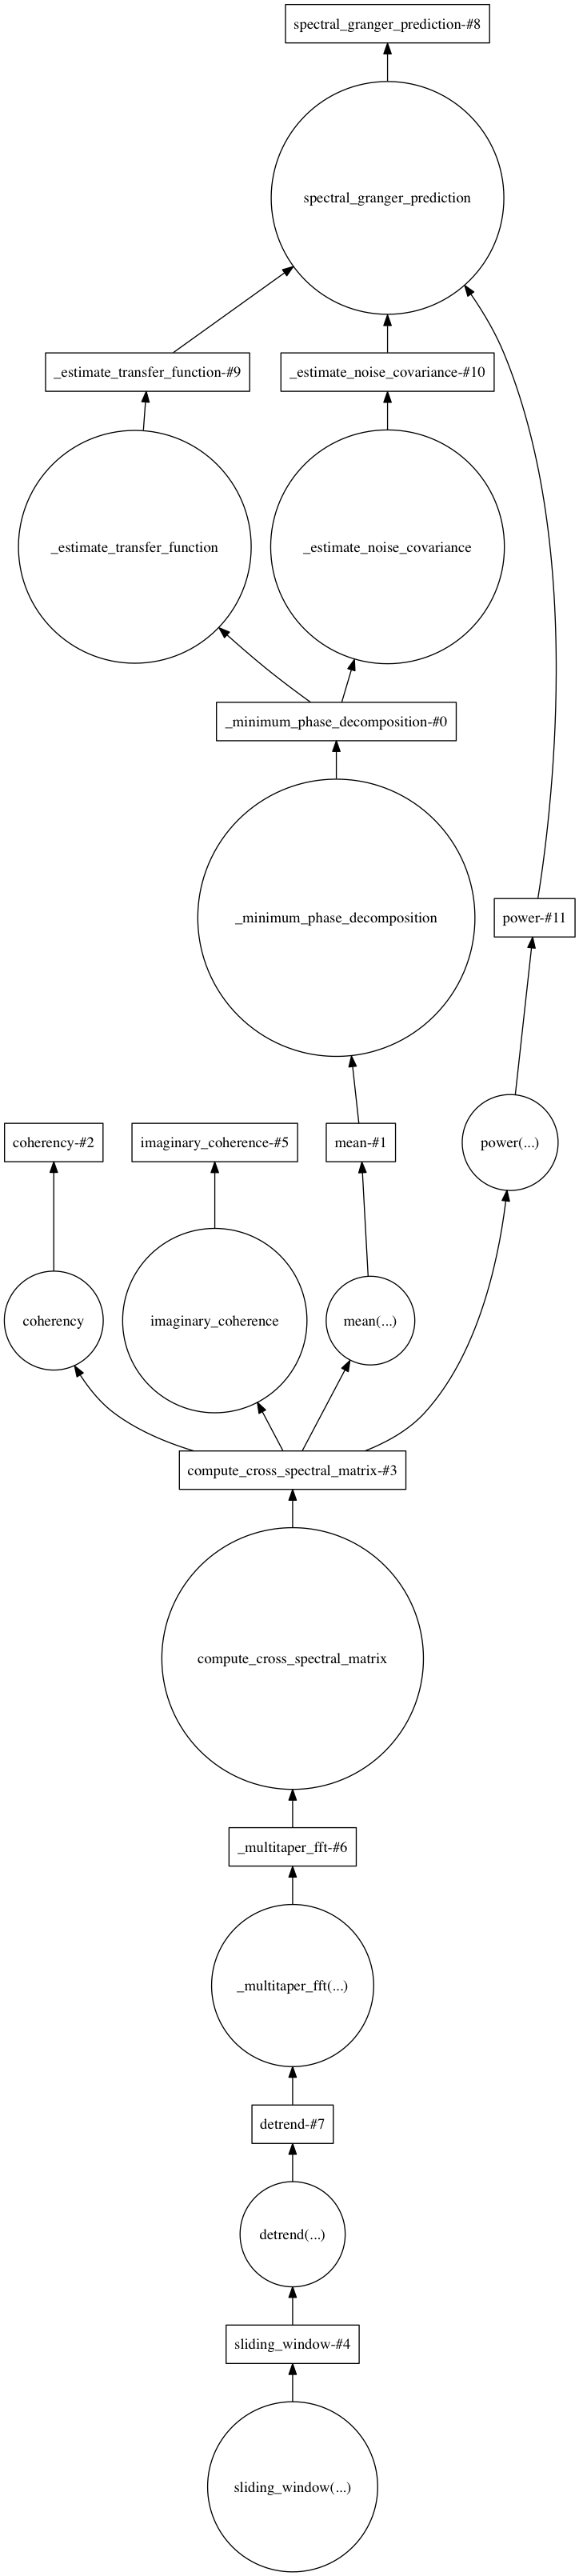

In [41]:
visualize(*(_spectral_granger, _coherencey, power_spectra, _imaginary_coherence))

In [42]:
blah = compute(*(_spectral_granger, _coherencey, power_spectra, _imaginary_coherence))

Maximum iterations reached. 0 of 30 converged


# Experiments with classes

In [637]:
from src.spectral import dpss_windows, _nextpower2
from scipy.stats import norm
from scipy.signal import detrend
from scipy.fftpack import fft, ifft
from functools import partial
from scipy.ndimage import label
from scipy.stats.mstats import linregress
from itertools import combinations

EXPECTATION = {
    'trials': partial(np.mean, axis=1),
    'tapers': partial(np.mean, axis=2),
    'trials_tapers': partial(np.mean, axis=(1, 2))
}

def compute_cross_spectral_matrix(fourier_coefficients):
    '''
    Parameters
    ----------
    fourier_coefficients : array-like, shape (n_time_samples, n_trials,
                                              n_signals, n_fft_samples,
                                              n_tapers)
                                              
    Returns
    -------
    cross_spectral_matrix : array-like, shape (n_time_samples, n_trials,
                                               n_tapers, n_fft_samples,
                                               n_signals, n_signals)
    '''
    fourier_coefficients = np.expand_dims(fourier_coefficients.swapaxes(2, -1), -1)
    return _complex_inner_product(fourier_coefficients, fourier_coefficients)


def _multitaper_fft(tapers, time_series, n_fft_samples,
                    sampling_frequency, axis=0):
    '''Projects the data on the tapers and returns the discrete Fourier
    transform

    Parameters
    ----------
    tapers : array_like, shape (n_time_samples, n_tapers)
    time_series : array_like, shape (n_windows, n_trials, n_time_samples)
    n_fft_samples : int
    sampling_frequency : int

    Returns
    -------
    fourier_coefficients : array_like, shape (n_windows, n_trials,
                                              n_fft_samples, n_tapers)

    '''
    n_dims = len(time_series.shape[:-1])
    projected_time_series = (np.reshape(time_series, (*time_series.shape, 1)) *
                             np.reshape(tapers, (1, 1, *tapers.shape)))
    return (fft(projected_time_series, n=n_fft_samples, axis=axis) /
            sampling_frequency)

def _make_tapers(n_time_samples, sampling_frequency,
                 time_halfbandwidth_product, n_tapers):
    '''Returns the Discrete prolate spheroidal sequences (tapers) for
    multi-taper spectral analysis.

    Parameters
    ----------
    n_time_samples : int
    sampling_frequency : int
    time_halfbandwidth_product : float
    n_tapers : int

    Returns
    -------
    tapers : array_like, shape (n_time_samples, n_tapers)

    '''
    tapers, _ = dpss_windows(
        n_time_samples, time_halfbandwidth_product, n_tapers)
    return tapers.T * np.sqrt(sampling_frequency)


def _bandpass(coherency, frequencies, frequencies_of_interest):
    frequency_index = ((frequencies_of_interest[0] < frequencies) &
                     (frequencies < frequencies_of_interest[1]))
    return coherency[..., frequency_index, :, :], frequencies[frequency_index]

def _get_independent_frequency_step(frequency_difference, frequency_resolution):
    '''Find the number of points of a frequency axis such that they
    are statistically independent.
    
    
    Parameters
    ----------
    frequency_difference : float
        The distance between two frequency points
    frequency_resolution : float
        The ability to resolve frequency points
    
    Returns
    -------
    frequency_step : int
        The number of points required so that two
        frequency points are statistically independent.
    '''
    return np.ceil(frequency_resolution / frequency_difference).astype(int)


def fisher_z_transform(coherency, bias):
    return (np.arctanh(np.abs(coherency)) - bias) / np.sqrt(bias)


def _get_normal_distribution_p_values(data, mean=0, std_deviation=1):
    return 1 - norm.cdf(data, loc=mean, scale=std_deviation)

def _find_largest_group(is_significant):
    labeled, _ = label(is_significant)
    label_groups, label_counts = np.unique(labeled, return_counts=True)

    if len(label_groups) > 1:
        label_counts[0] = 0
        max_group = label_groups[np.argmax(label_counts)]
        return labeled == max_group
    else:
        return np.zeros(is_significant.shape, dtype=bool)


def _filter_by_frequency_resolution(is_significant, frequency_step):
    index = is_significant.nonzero()[0]
    independent_index = index[slice(0, len(index), frequency_step)]
    return np.in1d(np.arange(0, len(is_significant)), independent_index)

def _find_largest_independent_group(is_significant, frequency_step, smallest_group_size=3):
    is_significant = _filter_by_frequency_resolution(
        _find_largest_group(is_significant),
        frequency_step)
    if sum(is_significant) >= smallest_group_size:
        return is_significant
    else:
        return np.zeros(is_significant.shape, dtype=bool)


def find_largest_significant_group(coherency, bias, frequency_step=1,
                                   significance_threshold=0.05, smallest_group_size=3):
    z_coherence = fisher_z_transform(coherency, bias)
    p_values = _get_normal_distribution_p_values(z_coherence)
    is_significant = p_values < significance_threshold
    return np.apply_along_axis(_find_largest_independent_group, -3,
                               is_significant, frequency_step,
                               smallest_group_size)


def _add_trial_axis(time_series):
    '''If no trial axis included, add one in
    '''
    return (time_series[:, np.newaxis, ...]
            if len(time_series.shape) < 3 else time_series)

def _conjugate_transpose(x):
    '''Conjugate transpose of the last two dimensions of array x'''
    return x.swapaxes(-1, -2).conjugate()


def _complex_inner_product(a, b):
    return np.matmul(a, _conjugate_transpose(b))
    
    
def _sliding_window(data, window_size, step_size=1,
                    padded=False, axis=-1, is_copy=True):
    '''
    Calculate a sliding window over a signal

    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    window_size : int
        Number of samples per window
    step_size : int
        Number of samples to step the window forward. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    is_copy : bool
        Return strided array as copy to avoid sideffects when manipulating
        the output array.

    Returns
    -------
    data : array-like
        A matrix where row in last dimension consists of one instance
        of the sliding window.

    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.

    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> _sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> _sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])

    References
    ----------
    .. [1] https://gist.github.com/nils-werner/9d321441006b112a4b116a8387c2280c

    '''
    shape = list(data.shape)
    shape[axis] = np.floor(
        (data.shape[axis] / step_size) - (window_size / step_size) + 1
    ).astype(int)
    shape.append(window_size)

    strides = list(data.strides)
    strides[axis] *= step_size
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides)

    return strided.copy() if is_copy else strided

def _conjugate_transpose(x):
    '''Conjugate transpose of the last two dimensions of array x'''
    return x.swapaxes(-1, -2).conjugate()


def _get_intial_conditions(cross_spectral_matrix):
    '''Returns a guess for the minimum phase factor'''
    return np.linalg.cholesky(
        ifft(cross_spectral_matrix, axis=-3)[..., 0:1, :, :].real
    ).swapaxes(-1, -2)


def _get_causal_signal(linear_predictor):
    '''Remove negative lags (the anti-casual part of the signal) and half of the zero lag
    to obtain the causal signal.
    Gives you A_(t+1)(Z) / A_(t)(Z)
    
    Takes half the roots on the unit circle (zero lag) and all the roots
    inside the unit circle (positive lags)
    
    This is the plus operator in Wilson
    '''
    n_signals, n_fft_samples = linear_predictor.shape[-1], linear_predictor.shape[-3]
    linear_predictor_coefficients = ifft(linear_predictor, axis=-3)
    linear_predictor_coefficients[..., 0, :, :] *= 0.5
    # Form S_tau
    lower_triangular_ind = np.tril_indices(n_signals, k=-1)
    linear_predictor_coefficients[..., 0, lower_triangular_ind[0], lower_triangular_ind[1]] = 0
    linear_predictor_coefficients[..., (n_fft_samples // 2) + 1:, :, :] = 0
    return fft(linear_predictor_coefficients, axis=-3)


def check_convergence(minimum_phase_factor, old_minimum_phase_factor, tolerance):
    '''Check convergence of Wilson algorithm at each time point'''
    n_time_points = minimum_phase_factor.shape[0]
    psi_error = np.linalg.norm(
        np.reshape(minimum_phase_factor - old_minimum_phase_factor, (n_time_points, -1)),
        ord=np.inf, axis=1)
    return psi_error < tolerance
    

def _minimum_phase_decomposition(cross_spectral_matrix, tolerance=1E-8, max_iterations=30):
    '''Using the Wilson algorithm to find a minimum phase matrix square root of the
    cross spectral density'''
    n_time_points, n_signals = cross_spectral_matrix.shape[0], cross_spectral_matrix.shape[-1]
    I = np.eye(n_signals)
    is_converged = np.zeros(n_time_points, dtype=bool)
    minimum_phase_factor = np.zeros(cross_spectral_matrix.shape)
    minimum_phase_factor[..., :, :, :] = _get_intial_conditions(cross_spectral_matrix)

    for iteration in range(max_iterations):
        old_minimum_phase_factor = minimum_phase_factor.copy()
        linear_predictor = (np.linalg.solve(
            minimum_phase_factor,
            _conjugate_transpose(np.linalg.solve(minimum_phase_factor, cross_spectral_matrix))) + I)
        minimum_phase_factor = np.matmul(minimum_phase_factor, _get_causal_signal(linear_predictor))
        
        minimum_phase_factor[is_converged, ...] = old_minimum_phase_factor[is_converged, ...]
        is_converged = check_convergence(minimum_phase_factor, old_minimum_phase_factor, tolerance)
        if np.all(is_converged):
            return minimum_phase_factor
    else:
        print('Maximum iterations reached. {} of {} converged'.format(
            is_converged.sum(), len(is_converged)))
        return minimum_phase_factor


def _estimate_noise_covariance(minimum_phase):
    A_0 = minimum_phase[..., 0, :, :]
    return np.matmul(A_0, A_0.swapaxes(-1, -2)).real


def _estimate_transfer_function(minimum_phase):
    return np.matmul(minimum_phase,
                     np.linalg.inv(minimum_phase[..., 0:1, :, :]))


def _magnitude(x):
    return np.abs(x) ** 2


def _remove_instantaneous_causality(noise_covariance):
    noise_covariance = noise_covariance[..., np.newaxis, :, :]
    variance = np.diagonal(noise_covariance, axis1=-1, axis2=-2)[..., np.newaxis] 
    return (_conjugate_transpose(variance) -
            noise_covariance * _conjugate_transpose(noise_covariance) / variance)


def _set_diagonal_to_zero(x):
    n_signals = x.shape[-1]
    diagonal_index = np.diag_indices(n_signals)
    x[..., diagonal_index[0], diagonal_index[1]] = 0
    return x


def _total_inflow(transfer_magnitude, noise_variance):
    return np.sum(noise_variance * transfer_magnitude, keepdims=True, axis=-1)


def _get_noise_variance(noise_covariance):
    if noise_covariance is None:
        return 1.0
    else:
        return np.diagonal(noise_covariance, axis1=-1, axis2=-2)[..., np.newaxis]


def _total_outflow(MVAR_Fourier_coefficients, noise_variance):
    return np.sum(
        (1.0 / noise_variance) * _magnitude(MVAR_Fourier_coefficients), keepdims=True, axis=-2)

def _reshape(fourier_coefficients):
    '''Combine trials and tapers dimensions'''
    print(fourier_coefficients.shape)
    n_time_samples, _, n_signals, n_fft_samples, _ = fourier_coefficients.shape
    return fourier_coefficients.swapaxes(1, 3).reshape(
        (n_time_samples, n_fft_samples, n_signals, -1))


def _normalize_fourier_coefficients(fourier_coefficients):
    U, _, V = np.linalg.svd(_reshape(fourier_coefficients), full_matrices=False)
    return np.matmul(U, V)


def _estimate_canonical_coherency(
        normalized_fourier_coefficients1, normalized_fourier_coefficients2):
    group_cross_spectrum = _complex_inner_product(
        normalized_fourier_coefficients1, normalized_fourier_coefficients2)
    return np.linalg.svd(group_cross_spectrum, full_matrices=False, compute_uv=False)[..., 0]


class lazyproperty:
    def __init__(self, func):
        self.func = func

    def __get__(self, instance, cls):
        if instance is None:
            return self
        else:
            value = self.func(instance)
            setattr(instance, self.func.__name__, value)
            return value

        
class Multitaper(object):
    def __init__(self, time_series, sampling_frequency=1000,
                 time_halfbandwidth_product=3, pad=0,
                 detrend_type='linear', time_window_duration=None,
                 time_window_step=None, n_tapers=None,  tapers=None,
                 start_time=0, n_fft_samples=None, n_time_samples=None,
                 n_samples_per_time_step=None):

        self.time_series = time_series
        self.sampling_frequency = sampling_frequency
        self.time_halfbandwidth_product = time_halfbandwidth_product
        self.pad = pad
        self.detrend_type = detrend_type
        self._time_window_duration = time_window_duration
        self._time_window_step = time_window_step
        self.start_time = start_time
        self._n_fft_samples = n_fft_samples
        self._tapers = tapers
        self._n_tapers = n_tapers
        self._n_time_samples = n_time_samples
        self._n_samples_per_time_step = n_samples_per_time_step

    @property
    def tapers(self):
        if self._tapers is None:
            self._tapers = _make_tapers(
                self.n_time_samples, self.sampling_frequency,
                self.time_halfbandwidth_product, self.n_tapers)
        return self._tapers

    @property
    def time_window_duration(self):
        if self._time_window_duration is None:
            self._time_window_duration = (self.n_time_samples /
                                          self.sampling_frequency)
        return self._time_window_duration

    @property
    def time_window_step(self):
        if self._time_window_step is None:
            self._time_window_step = (self.n_samples_per_time_step /
                                      self.sampling_frequency)
        return self._time_window_step

    @property
    def n_tapers(self):
        return np.floor(
                2 * self.time_halfbandwidth_product - 1).astype(int)

    @property
    def n_time_samples(self):
        if (self._n_time_samples is None and
                self._time_window_duration is None):
            self._n_time_samples = self.time_series.shape[0]
        elif self._time_window_duration is not None:
            self._n_time_samples = np.fix(
                self.time_window_duration * self.sampling_frequency
                ).astype(int)
        return self._n_time_samples

    @property
    def n_fft_samples(self):
        if self._n_fft_samples is None:
            next_exponent = _nextpower2(self.n_time_samples)
            self._n_fft_samples = max(2 ** (next_exponent + self.pad),
                                      self.n_time_samples)
        return self._n_fft_samples

    @property
    def frequencies(self):
        positive_frequencies = np.linspace(
            0, self.sampling_frequency, num=self.n_fft_samples // 2 + 1)
        return np.concatenate((positive_frequencies,
                               -1 * positive_frequencies[-2:0:-1]))

    @property
    def n_samples_per_time_step(self):
        '''If `time_window_step` is set, then calculate the
        `n_samples_per_time_step` based on the time window duration. If
        `time_window_step` and `n_samples_per_time_step` are both not set,
        default the window step size to the same size as the window.
        '''
        if (self._n_samples_per_time_step is None and
                self._time_window_step is None):
            self._n_samples_per_time_step = self.n_time_samples
        elif self._time_window_step is not None:
            self._n_samples_per_time_step = np.fix(
                self.time_window_step * self.sampling_frequency
                ).astype(int)
        return self._n_samples_per_time_step

    @property
    def time(self):
        time_ind = np.arange(
            0, self.time_series.shape[0] - 1,
            step=self.n_samples_per_time_step)
        return self.start_time + (time_ind / self.sampling_frequency)

    @property
    def n_signals(self):
        return self.time_series.shape[-1]

    @property
    def n_trials(self):
        return (1 if len(self.time_series.shape) < 3 else
                self.time_series.shape[1])

    @property
    def frequency_resolution(self):
        return (self.time_halfbandwidth_product /
                self.time_window_duration)

    def fft(self):
        time_series = _add_trial_axis(self.time_series)
        time_series = _sliding_window(
            time_series, window_size=self.n_time_samples,
            step_size=self.n_samples_per_time_step, axis=0)
        time_series = detrend(time_series, type=self.detrend_type)

        return _multitaper_fft(self.tapers, time_series,
                               self.n_fft_samples, self.sampling_frequency,
                               axis=3)

class Connectivity(object):
    def __init__(self, fourier_coefficients, frequencies_of_interest=None,
                 expectation_type='trials_tapers'):
        self.fourier_coefficients = fourier_coefficients
        self.frequencies_of_interest = frequencies_of_interest
        self.expectation_type = expectation_type

    @lazyproperty
    def cross_spectral_matrix(self):
        return compute_cross_spectral_matrix(self.fourier_coefficients)

    @lazyproperty
    def power(self):
        fourier_coefficients = self.fourier_coefficients.swapaxes(2, -1)
        return self.expectation(fourier_coefficients *
                                fourier_coefficients.conjugate())

    @lazyproperty
    def minimum_phase_factor(self):
        return _minimum_phase_decomposition(
            self.expectation(self.cross_spectral_matrix))

    @lazyproperty
    def transfer_function(self):
        return _estimate_transfer_function(self.minimum_phase_factor)

    @lazyproperty
    def noise_covariance(self):
        return _estimate_noise_covariance(self.minimum_phase_factor)

    @lazyproperty
    def MVAR_Fourier_coefficients(self):
        return np.linalg.inv(self.transfer_function)
    
    @property
    def expectation(self):
        return EXPECTATION[self.expectation_type]
    
    @property
    def n_observations(self):
        axes = signature(self.expectation).parameters['axis'].default
        if isinstance(axes, int):
            return self.cross_spectral_matrix.shape[axes]
        else:
            return np.prod(
                [self.cross_spectral_matrix.shape[axis] for axis
                 in axes])

    @property
    def bias(self):
        degrees_of_freedom = 2 * self.n_observations
        return 1 / (degrees_of_freedom - 2)

    def coherency(self):
        return self.expectation(self.cross_spectral_matrix) / np.sqrt(
            self.power[..., :, np.newaxis] *
            self.power[..., np.newaxis, :])
    
    def coherence_phase(self):
        return np.angle(self.coherency())
    
    def coherence_magnitude(self):
        return np.abs(self.coherency)
    
    def imaginary_coherence(self):
        return np.abs(
            self.expectation(self.cross_spectral_matrix).imag /
                  np.sqrt(self.power[..., :, np.newaxis] *
                          self.power[..., np.newaxis, :]))

    
    def canonical_coherence(self, group_labels):
        labels = np.unique(group_labels)
        normalized_fourier_coefficients = [
            _normalize_fourier_coefficients(
                self.fourier_coefficients[:, :, np.in1d(group_labels, label), ...])
            for label in labels]
        return np.stack([
            _estimate_canonical_coherency(fourier_coefficients1, fourier_coefficients2)
                for fourier_coefficients1, fourier_coefficients2
                in combinations(normalized_fourier_coefficients, 2)
        ], axis=-1), list(combinations(labels, 2))
    
    def phase_locking_value(self):
        return self.expectation(
            self.cross_spectral_matrix /
            np.abs(self.cross_spectral_matrix))
    
    def phase_lag_index(self):
        return self.expectation(
            np.sign(self.cross_spectral_matrix.imag))
    
    def weighted_phase_lag_index(self):
        pli = self.phase_lag_index()
        weights = self.expectation(
            np.abs(self.cross_spectral_matrix.imag))
        with np.errstate(divide='ignore', invalid='ignore'):
            return pli / weights
    
    def debiased_squared_phase_lag_index(self):
        n_observations = self.n_observations
        return ((n_observations * self.phase_lag_index() ** 2 - 1.0) /
                (n_observations - 1.0))
        
    def debiased_squared_weighted_phase_lag_index(self):
        n_observations = self.n_observations
        imaginary_cross_spectral_matrix_sum = self.expectation(
            self.cross_spectral_matrix.imag) * n_observations
        squared_imaginary_cross_spectral_matrix_sum = self.expectation(
            self.cross_spectral_matrix.imag ** 2) * n_observations
        imaginary_cross_spectral_matrix_magnitude_sum = self.expectation(
            np.abs(self.cross_spectral_matrix.imag)) * n_observations
        weights = (imaginary_cross_spectral_matrix_magnitude_sum ** 2 -
                   squared_imaginary_cross_spectral_matrix_sum)
        return (imaginary_cross_spectral_matrix_sum ** 2 -
                squared_imaginary_cross_spectral_matrix_sum) / weights
    
    def pairwise_phase_consistency(self):
        n_observations = self.n_observations
        plv_sum = self.phase_locking_value() * n_observations
        ppc = ((plv_sum * plv_sum.conjugate() - n_observations) /
               (n_observations * (n_observations - 1.0)))
        return ppc.real
    
    def spectral_granger_prediction(self):
        partial_covariance = _remove_instantaneous_causality(self.noise_covariance)
        intrinsic_power = (self.power[..., np.newaxis] -
                           partial_covariance * _magnitude(self.transfer_function))
        return _set_diagonal_to_zero(np.log(
            self.power[..., np.newaxis] / intrinsic_power))
    
    def directed_transfer_function(self, is_directed_coherence=False):
        if is_directed_coherence:
            noise_variance = np.diagonal(self.noise_covariance, axis1=-1, axis2=-2)[
                ..., np.newaxis, :, np.newaxis]
        else:
            noise_variance = 1.0

        transfer_magnitude = _magnitude(self.transfer_function)
        return (np.sqrt(noise_variance) * transfer_magnitude /
                _total_inflow(transfer_magnitude, noise_variance))
    
    def partial_directed_coherence(self, is_generalized=False):
        if is_generalized:
            noise_variance = np.diagonal(self.noise_covariance, axis1=-1, axis2=-2)[
                ..., np.newaxis, :, np.newaxis]
        else:
            noise_variance = 1.0
        return (self.MVAR_Fourier_coefficients * (1.0 / np.sqrt(noise_variance)) /
                _total_outflow(self.MVAR_Fourier_coefficients, noise_variance))

    def direct_directed_transfer_function(self):
        transfer_magnitude = _magnitude(self.transfer_function)
        full_frequency_DTF = transfer_magnitude / np.sum(
            _total_inflow(transfer_magnitude, 1.0), axis=-3, keepdims=True)
        return full_frequency_DTF * self.partial_directed_coherence()
    
    def group_delay(self, frequencies_of_interest=None,
                    frequencies=None, frequency_resolution=None):
        frequency_difference = frequencies[1] - frequencies[0]
        independent_frequency_step = _get_independent_frequency_step(frequency_difference, frequency_resolution)
        bandpassed_coherency, bandpassed_frequencies = _bandpass(
            self.coherency(), frequencies, frequencies_of_interest)
        is_significant = find_largest_significant_group(
            bandpassed_coherency, self.bias, independent_frequency_step)
        coherence_phase = np.ma.masked_array(
            np.unwrap(np.angle(bandpassed_coherency), axis=-3), mask=~is_significant)
        
        def _linear_regression(response):
            return linregress(bandpassed_frequencies, y=response)
        
        regression_results = np.ma.apply_along_axis(_linear_regression, -3, coherence_phase)
        slope = np.array(regression_results[..., 0, :, :], dtype=np.float)
        delay = slope / (2 * np.pi)
        r_value = np.array(regression_results[..., 2, :, :], dtype=np.float)
        return delay, slope, r_value
    
    def phase_slope_index(self, frequencies_of_interest=None,
                    frequencies=None, frequency_resolution=None):
        bandpassed_coherency, frequencies = _bandpass(
            self.coherency(), frequencies, frequencies_of_interest)
        n_frequencies = bandpassed_coherency.shape[-3]
        psi = (bandpassed_coherency[..., :, np.newaxis, :, :].conj() *
               bandpassed_coherency[..., np.newaxis, :, :, :])
        lower_triangular_ind = np.tril_indices(n_frequencies)
        psi[..., lower_triangular_ind[0], lower_triangular_ind[1], :, :] = 0
        return np.imag(psi.sum(axis=(-3, -4)))
        

In [4]:
m = Multitaper(np.stack(data.copy(), axis=-1),
               sampling_frequency=1500,
               time_window_duration=0.08,
               time_halfbandwidth_product=3,
               detrend_type='constant',
               start_time=time[0])
c = Connectivity(fourier_coefficients=m.fft())

NameError: name 'Multitaper' is not defined

In [260]:
vars(c).keys()

dict_keys(['fourier_coefficients', 'expectation_type', 'frequencies_of_interest'])

In [261]:
coh = c.coherency()
vars(c).keys()

dict_keys(['frequencies_of_interest', 'power', 'fourier_coefficients', 'cross_spectral_matrix', 'expectation_type'])

In [262]:
im_coh = c.imaginary_coherence()
vars(c).keys()

dict_keys(['frequencies_of_interest', 'power', 'fourier_coefficients', 'cross_spectral_matrix', 'expectation_type'])

In [263]:
granger = c.spectral_granger_prediction()
vars(c).keys()

Maximum iterations reached. 0 of 30 converged


dict_keys(['minimum_phase_factor', 'transfer_function', 'frequencies_of_interest', 'power', 'fourier_coefficients', 'cross_spectral_matrix', 'expectation_type', 'noise_covariance'])

In [264]:
wPLI = c.weighted_phase_lag_index()
vars(c).keys()

dict_keys(['minimum_phase_factor', 'transfer_function', 'frequencies_of_interest', 'power', 'fourier_coefficients', 'cross_spectral_matrix', 'expectation_type', 'noise_covariance'])

In [265]:
DTF = c.directed_transfer_function()
vars(c).keys()

dict_keys(['minimum_phase_factor', 'transfer_function', 'frequencies_of_interest', 'power', 'fourier_coefficients', 'cross_spectral_matrix', 'expectation_type', 'noise_covariance'])

In [266]:
DTF = c.directed_transfer_function(is_directed_coherence=True)
vars(c).keys()

dict_keys(['minimum_phase_factor', 'transfer_function', 'frequencies_of_interest', 'power', 'fourier_coefficients', 'cross_spectral_matrix', 'expectation_type', 'noise_covariance'])

In [267]:
PDC = c.partial_directed_coherence()
vars(c).keys()

dict_keys(['minimum_phase_factor', 'transfer_function', 'frequencies_of_interest', 'power', 'fourier_coefficients', 'cross_spectral_matrix', 'MVAR_Fourier_coefficients', 'expectation_type', 'noise_covariance'])

In [268]:
psi = c.phase_slope_index(frequencies_of_interest=[100, 300],
                    frequencies=m.frequencies, frequency_resolution=m.frequency_resolution)
vars(c).keys()

dict_keys(['minimum_phase_factor', 'transfer_function', 'frequencies_of_interest', 'power', 'fourier_coefficients', 'cross_spectral_matrix', 'MVAR_Fourier_coefficients', 'expectation_type', 'noise_covariance'])

In [269]:
gd = c.group_delay(frequencies_of_interest=[100, 300],
                   frequencies=m.frequencies,
                   frequency_resolution=m.frequency_resolution)
vars(c).keys()

/Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/spectral/statistics.py:95: RuntimeWarning: divide by zero encountered in arctanh
  z1 = np.arctanh(np.abs(coherency1)) - bias1


dict_keys(['minimum_phase_factor', 'transfer_function', 'frequencies_of_interest', 'power', 'fourier_coefficients', 'cross_spectral_matrix', 'MVAR_Fourier_coefficients', 'expectation_type', 'noise_covariance'])

In [270]:
psi = c.phase_slope_index(frequencies_of_interest=[100, 300],
                          frequencies=m.frequencies,
                          frequency_resolution=m.frequency_resolution)
vars(c).keys()

dict_keys(['minimum_phase_factor', 'transfer_function', 'frequencies_of_interest', 'power', 'fourier_coefficients', 'cross_spectral_matrix', 'MVAR_Fourier_coefficients', 'expectation_type', 'noise_covariance'])

In [94]:
cc = c.canonical_coherence(['a', 'b'])

In [677]:
# Faster way to compute combinations?

combination_index = np.array(list(combinations(range(n_frequencies), 2)))
blah = (bandpassed_coherency[..., combination_index[:, 0], :, :].conjugate() *
 bandpassed_coherency[..., combination_index[:, 1], :, :]).sum(axis=-3)

def _simple_slice(arr, inds, axis):
    # this does the same as np.take() except only supports simple slicing, not
    # advanced indexing, and thus is much faster
    sl = [slice(None)] * arr.ndim
    sl[axis] = inds
    return arr[sl]

def inner_combination(x, axis=-1):
    n_data = x.shape[axis]
    combination_index = np.array(list(combinations(range(n_data), 2)))
    return (_simple_slice(x, combination_index[:, 0], axis).conjugate() *
            _simple_slice(x, combination_index[:, 1], axis)).sum(axis=axis)

np.allclose(blah, inner_combination(bandpassed_coherency, axis=-3))

True

In [59]:
m = Multitaper(np.stack(data.copy(), axis=-1),
               sampling_frequency=1500,
               time_halfbandwidth_product=3,
               detrend_type='constant',
               start_time=time[0])

In [66]:
m.time_window_duration

2.4006666666666665

In [67]:
m.n_time_samples

3601

In [199]:
from src.spectral.transforms import Multitaper
from src.spectral.connectivity import Connectivity

m = Multitaper(np.stack(data.copy(), axis=-1),
               sampling_frequency=1500,
               time_window_duration=0.08,
               time_halfbandwidth_product=3,
               detrend_type='constant',
               start_time=time[0])
c = Connectivity(fourier_coefficients=m.fft())

In [262]:
csd = np.zeros((1, 1, 2, 2), dtype=np.complex)
print('csd:')
print(csd.squeeze())
print('\ncausal:')
print(_get_causal_signal(csd).squeeze())

csd:
[[ 0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]

causal:
[[ 0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]


In [263]:
csd = np.ones((1, 1, 2, 2), dtype=np.complex)
print('csd:')
print(csd.squeeze())
print('\ncausal:')
print(_get_causal_signal(csd).squeeze())

csd:
[[ 1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j]]

causal:
[[ 0.5+0.j  0.5+0.j]
 [ 0.0+0.j  0.5+0.j]]


In [264]:
csd = 2 * np.ones((1, 1, 2, 2), dtype=np.complex)
print('csd:')
print(csd.squeeze())
print('\ncausal:')
print(_get_causal_signal(csd).squeeze())

csd:
[[ 2.+0.j  2.+0.j]
 [ 2.+0.j  2.+0.j]]

causal:
[[ 1.+0.j  1.+0.j]
 [ 0.+0.j  1.+0.j]]


In [265]:
csd = 0.5 * np.ones((1, 1, 2, 2), dtype=np.complex)
print('csd:')
print(csd.squeeze())
print('\ncausal:')
print(_get_causal_signal(csd).squeeze())

csd:
[[ 0.5+0.j  0.5+0.j]
 [ 0.5+0.j  0.5+0.j]]

causal:
[[ 0.25+0.j  0.25+0.j]
 [ 0.00+0.j  0.25+0.j]]


In [266]:
csd = 0.5 * np.exp(1j * np.pi / 4) * np.ones((1, 1, 2, 2), dtype=np.complex)
print('csd:')
print(csd.squeeze())
print('\ncausal:')
print(_get_causal_signal(csd).squeeze())

csd:
[[ 0.35355339+0.35355339j  0.35355339+0.35355339j]
 [ 0.35355339+0.35355339j  0.35355339+0.35355339j]]

causal:
[[ 0.1767767+0.1767767j  0.1767767+0.1767767j]
 [ 0.0000000+0.j         0.1767767+0.1767767j]]


In [267]:
csd = 2 * np.exp(1j * np.pi / 4) * np.ones((1, 1, 2, 2), dtype=np.complex)
print('csd:')
print(csd.squeeze())
print('\ncausal:')
print(_get_causal_signal(csd).squeeze())

csd:
[[ 1.41421356+1.41421356j  1.41421356+1.41421356j]
 [ 1.41421356+1.41421356j  1.41421356+1.41421356j]]

causal:
[[ 0.70710678+0.70710678j  0.70710678+0.70710678j]
 [ 0.00000000+0.j          0.70710678+0.70710678j]]


In [292]:
csd = np.zeros((1, 1, 2, 2), dtype=np.complex)
csd[0, 0, 0, 0] = 0.5 * np.exp(1j * np.pi / 2)
csd[0, 0, 0, 1] = 0.5 * np.exp(1j * np.pi / 4)
csd[0, 0, 1, 1] = 3 * np.exp(1j * np.pi / 4)
csd[0, 0, 1, 0] = csd[0, 0, 0, 1].conj()
print('csd:')
print(csd.squeeze())
print('\ncausal:')
print(_get_causal_signal(csd).squeeze())

csd:
[[  3.06161700e-17+0.5j          3.53553391e-01+0.35355339j]
 [  3.53553391e-01-0.35355339j   2.12132034e+00+2.12132034j]]

causal:
[[  1.53080850e-17+0.25j         1.76776695e-01+0.1767767j ]
 [  0.00000000e+00+0.j           1.06066017e+00+1.06066017j]]


In [293]:
csd = np.zeros((1, 1, 2, 2), dtype=np.complex)
csd[0, 0, 0, 0] = 0.5 * np.exp(1j * np.pi / 2)
csd[0, 0, 0, 1] = 0.5 * np.exp(1j * 5 * np.pi / 4)
csd[0, 0, 1, 1] = 3 * np.exp(1j * -np.pi / 4)
csd[0, 0, 1, 0] = csd[0, 0, 0, 1].conj()
print('csd:')
print(csd.squeeze())
print('\ncausal:')
print(_get_causal_signal(csd).squeeze())

csd:
[[  3.06161700e-17+0.5j         -3.53553391e-01-0.35355339j]
 [ -3.53553391e-01+0.35355339j   2.12132034e+00-2.12132034j]]

causal:
[[  1.53080850e-17+0.25j        -1.76776695e-01-0.1767767j ]
 [  0.00000000e+00+0.j           1.06066017e+00-1.06066017j]]


In [12]:
csd = np.zeros((1, 4, 2, 2), dtype=np.complex)
csd[0, 0, 0, 0] = 1.50 * np.exp(1j * np.pi / 2)
csd[0, 0, 0, 1] = 0.75 * np.exp(1j * np.pi / 4)
csd[0, 0, 1, 1] = 0.50 * np.exp(1j * np.pi / 4)
csd[0, 0, 1, 0] = csd[0, 0, 0, 1].conj()

csd[0, 1, 0, 0] = 1.50 * np.exp(1j * np.pi / 2)
csd[0, 1, 0, 1] = 0.75 * np.exp(1j * np.pi / 4)
csd[0, 1, 1, 1] = 0.50 * np.exp(1j * np.pi / 4)
csd[0, 1, 1, 0] = csd[0, 1, 0, 1].conj()

csd[0, 2, 0, 0] = 1.50 * np.exp(1j * np.pi / 2)
csd[0, 2, 0, 1] = 0.75 * np.exp(1j * np.pi / 4)
csd[0, 2, 1, 1] = 0.50 * np.exp(1j * np.pi / 4)
csd[0, 2, 1, 0] = csd[0, 0, 0, 1].conj()

csd[0, 3, 0, 0] = 1.50 * np.exp(1j * np.pi / 2)
csd[0, 3, 0, 1] = 0.75 * np.exp(1j * np.pi / 4)
csd[0, 3, 1, 1] = 0.50 * np.exp(1j * np.pi / 4)
csd[0, 3, 1, 0] = csd[0, 1, 0, 1].conj()

print('csd:')
print(csd.squeeze())
print('\ncausal:')
print(_get_causal_signal(csd).squeeze())

csd:
[[[  9.18485099e-17+1.5j          5.30330086e-01+0.53033009j]
  [  5.30330086e-01-0.53033009j   3.53553391e-01+0.35355339j]]

 [[  9.18485099e-17+1.5j          5.30330086e-01+0.53033009j]
  [  5.30330086e-01-0.53033009j   3.53553391e-01+0.35355339j]]

 [[  9.18485099e-17+1.5j          5.30330086e-01+0.53033009j]
  [  5.30330086e-01-0.53033009j   3.53553391e-01+0.35355339j]]

 [[  9.18485099e-17+1.5j          5.30330086e-01+0.53033009j]
  [  5.30330086e-01-0.53033009j   3.53553391e-01+0.35355339j]]]

causal:
[[[  4.59242550e-17+0.75j         2.65165043e-01+0.26516504j]
  [  0.00000000e+00+0.j           1.76776695e-01+0.1767767j ]]

 [[  4.59242550e-17+0.75j         2.65165043e-01+0.26516504j]
  [  0.00000000e+00+0.j           1.76776695e-01+0.1767767j ]]

 [[  4.59242550e-17+0.75j         2.65165043e-01+0.26516504j]
  [  0.00000000e+00+0.j           1.76776695e-01+0.1767767j ]]

 [[  4.59242550e-17+0.75j         2.65165043e-01+0.26516504j]
  [  0.00000000e+00+0.j           1.767766

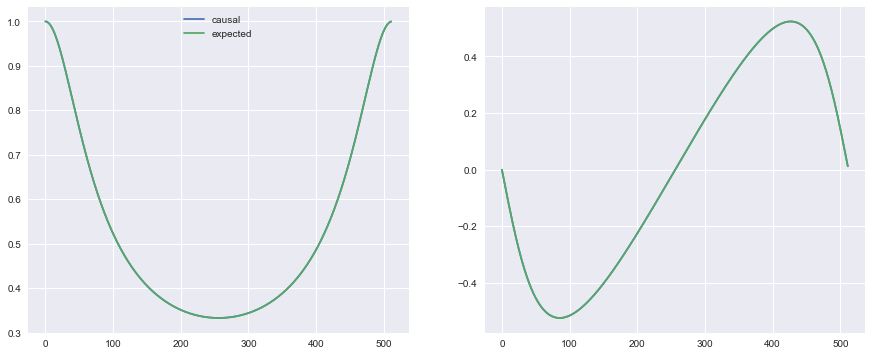

In [468]:
n_signals = 1
_, transfer_function = freqz_zpk(0.25, 0.5, 1.00, whole=True)
n_fft_samples = transfer_function.shape[0]
linear_predictor = np.zeros(
    (1, n_fft_samples, n_signals, n_signals), dtype=np.complex)
linear_predictor[0, :, 0, 0] = transfer_function

_, expected_transfer_function = freqz_zpk(0.25, 0.5, 1.00, whole=True)
linear_coef = ifft(expected_transfer_function)
linear_coef[0] *= 0.5

expected_causal_signal = np.zeros(
    (1, n_fft_samples, n_signals, n_signals), dtype=np.complex)
expected_causal_signal[0, :, 0, 0] = fft(linear_coef)


causal_signal = _get_causal_signal(linear_predictor)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(np.abs(causal_signal.squeeze()), label='causal');
ax[0].plot(np.abs(expected_causal_signal.squeeze()), label='expected');
ax[0].legend(loc='upper center')
ax[1].plot(np.angle(causal_signal.squeeze()));
ax[1].plot(np.angle(expected_causal_signal.squeeze()));